**Para este proyecto vamos hacer uso de los df usados anteriormente y los vamos a juntar**

**Importamos las librerías a utilizar**

In [0]:
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim
import requests 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

**Primero importamos el df de NY y agregamos una columna city**

In [53]:
ruta = '/home/barrios_ny.csv'
df_ny = pd.read_csv(ruta)
df_ny.drop('Unnamed: 0',axis = 1, inplace = True)
df_ny['City'] = 'NY'
mover_columnas = [df_ny.columns[-1]] + list(df_ny.columns[:-1])
df_ny = df_ny[mover_columnas]
df_ny.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,NY,Bronx,Wakefield,40.894705,-73.847201
1,NY,Bronx,Co-op City,40.874294,-73.829939
2,NY,Bronx,Eastchester,40.887556,-73.827806
3,NY,Bronx,Fieldston,40.895437,-73.905643
4,NY,Bronx,Riverdale,40.890834,-73.912585


In [61]:
df_ny.shape

(306, 5)

**Importamos el df de Toronto y borramos la columna de COD POstal y agregamos una columna City**

In [58]:
ruta = '/home/barrios_toronto.csv'
df_to = pd.read_csv(ruta)
df_to.drop(['Unnamed: 0','Postal Code'], axis = 1 , inplace=True)
df_to['City'] = 'Toronto'
fixed_columns = [df_to.columns[-1]] + list(df_to.columns[:-1])
df_to = df_to[fixed_columns]
df_to.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [63]:
df_to.shape

(103, 5)

**Una vez importados los DF los juntamos**

1.   Hacemos uso de concat para juntar las filas de ambos DF
2.   usamos reset_index para reiniciar el indice del nuevo df



In [84]:
df_to_ny = pd.concat([df_ny,df_to])
df_to_ny.reset_index()
print(df_to_ny.head())
print(df_to_ny.shape)

  City Borough Neighborhood   Latitude  Longitude
0   NY   Bronx    Wakefield  40.894705 -73.847201
1   NY   Bronx   Co-op City  40.874294 -73.829939
2   NY   Bronx  Eastchester  40.887556 -73.827806
3   NY   Bronx    Fieldston  40.895437 -73.905643
4   NY   Bronx    Riverdale  40.890834 -73.912585
(409, 5)


**Ubicamos nuestros vecindarios en un mapa**

In [92]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordenadas {}, {}.'.format(latitude, longitude))

Coordenadas 43.6534817, -79.3839347.


In [97]:
map_to_my = folium.Map(location=[latitude,longitude], zoom_start=6)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_to_ny['Latitude'], df_to_ny['Longitude'], df_to_ny['Borough'], df_to_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='green',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to_my)  
map_to_my

**Ahora que ya tenemos listo nuesto DF procedemos a conectarnos Forsquare.**

**Por seguridad terminada el Notebook , se borraran las credenciales**

In [0]:
CLIENT_ID = 'MPS5EM5OHF5W40AKIFBJV2W4RG3C2L2KJOMAEKBMZ3LQLJHZ' 
CLIENT_SECRET = 'IO3SXEE3XX5TWAOFKVZJP2Z5GNFNF1O2WCTXAAFBSCAE2CS4' #
VERSION = '20180605' 

**Creamos una funcion para obtener los 100 mejores lugares que se encuentran a 500 metros de cada barrio**

In [0]:
LIMIT = 100
def obtener_lugares(names, latitudes, longitudes, radius=500):
    
    lista_lugar=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Creamos el API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # Realizamos la solicitud
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Retornamos información relevante
        lista_lugar.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    df_lugares = pd.DataFrame([item for lista_lugar in lista_lugar for item in lista_lugar])
    df_lugares.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(df_lugares)

**Le pasamos los parametros a la funcion creada anteriormnete para obtener el df con los lugares mas cercanos de los vecindarios de nuestro df_to_ny**

In [0]:
df_tony_lug = obtener_lugares(names=df_to_ny['Neighborhood'],
                                   latitudes=df_to_ny['Latitude'],
                                   longitudes=df_to_ny['Longitude'])

**Vemos cuantas filas y columnas tenemos e imprimos los 5 primeros registros**

In [137]:
print(df_tony_lug.shape)
df_tony_lug.head()

(12089, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


**Hacemos un analisis para ver las categorías mas comunes y valores unicos**

In [139]:
df_tony_lug['Venue Category'].describe(include='all')

count           12089
unique            463
top       Pizza Place
freq              510
Name: Venue Category, dtype: object

In [147]:
df_categorías = df_tony_lug['Venue Category'].value_counts()
df_categorías.head(20).to_frame()

,Venue Category
Pizza Place,510
Coffee Shop,486
Italian Restaurant,340
Deli / Bodega,275
Café,272
Bakery,261
Bar,253
Sandwich Place,236
Park,226
Chinese Restaurant,221


**Ahora verificamos cuantos lugares nos devuelve por cada vecindario**

In [149]:
df_tony_lug.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
Allerton,26,26,26,26,26,26
Annadale,14,14,14,14,14,14
Arden Heights,4,4,4,4,4,4


**Ahora vamos analizar cada vecindario**

**Convertimos cada fila de las categorías en columnas para asociarlas con los vecindarios y ver cuantos lugares de cada categoria hay por vecindario**

In [204]:
df_cate = pd.get_dummies(df_tony_lug['Venue Category'])
df_cate['Neighborhood'] = df_tony_lug['Neighborhood']
ord_colum = [df_cate.columns[-171]]+list(df_cate.columns[:-171])
df_cate = df_cate[ord_colum]
print(df_cate.shape)
df_cate.head()

(12089, 293)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,...,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Agrupamos el dataframe por vecindario , usando la media de los lugares**

In [255]:
df_g = df_cate.groupby('Neighborhood').mean().reset_index()
print(df_g.shape)
df_g.head()

(395, 293)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,...,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Vemos el tamaño del DF**

In [209]:
df_g.shape

(395, 293)

**Creamo una funcion para ordenar los lugares en forma descendente**

In [0]:
def return_most_common_venues(row, top_lugares):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_lugares]

**Creamos un nuevo marco de datos para visualizar los mjores 10 lugares por cada vencidario**

In [232]:
top_lugares = 10
indicators = ['st', 'nd', 'rd']

#Creamos columnas de acuerdo al top
columns = ['Neighborhood']
for ind in np.arange(top_lugares):
    try:
        columns.append('{}{} mas comun'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th mas comun'.format(ind+1))

# create a new dataframe
df_top = pd.DataFrame(columns=columns)
df_top['Neighborhood'] = df_g['Neighborhood']

for ind in np.arange(df_g.shape[0]):
    df_top.iloc[ind, 1:] = return_most_common_venues(df_g.iloc[ind, :], top_lugares)

df_top.head()

,Neighborhood,1st mas comun,2nd mas comun,3rd mas comun,4th mas comun,5th mas comun,6th mas comun,7th mas comun,8th mas comun,9th mas comun,10th mas comun
0,Agincourt,Clothing Store,Latin American Restaurant,Lounge,Breakfast Spot,College Auditorium,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building
1,"Alderwood, Long Branch",Dance Studio,Gym,Athletics & Sports,Coffee Shop,Nail Salon,Club House,Cocktail Bar,College Academic Building,College Arts Building,College Auditorium
2,Allerton,Deli / Bodega,Chinese Restaurant,Discount Store,Intersection,Grocery Store,Gas Station,Breakfast Spot,Fast Food Restaurant,Bakery,Fried Chicken Joint
3,Annadale,Dance Studio,American Restaurant,Deli / Bodega,Food,Diner,Cosmetics Shop,Clothing Store,Club House,Cocktail Bar,Coffee Shop
4,Arden Heights,Bus Stop,Coffee Shop,Comfort Food Restaurant,Clothing Store,Club House,Cocktail Bar,College Academic Building,College Arts Building,College Auditorium,College Basketball Court


**Elimnamos la columna Neighborhood del df df_toronto_g, para crear el df df_toronto_cluster y ejecutar el modelo de cluster**

In [233]:
df_clustes = df_g.drop('Neighborhood',1)
df_clustes.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,...,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Hacemos uso de la grafica del Codo para saber la cantidad optima de cluster , usaremos 5 cluster**

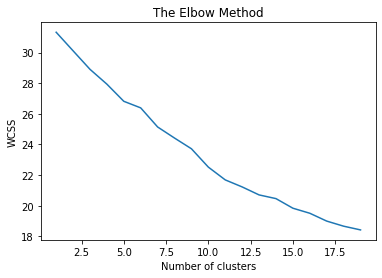

In [249]:
# Metodo del Codo para encontrar el numero optimo de clusters
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 6)
    kmeans.fit(df_clustes)
    wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Corremos el modelo**

In [250]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustes)
kmeans.labels_[0:10] 

array([8, 5, 8, 8, 5, 3, 3, 8, 0, 8], dtype=int32)

**Creemos un nuevo marco de datos que incluya el clúster y los 10 mejores lugares para cada vecindario**

In [0]:
#Agregamos al df df_toronto_top(que tiene el top10 de los mejores sitios) las etiquetas de cluster
df_top.insert(0, 'Cluster_Labels', kmeans.labels_)

In [256]:
#CReamos un nuevo dataframe y le pasamos el dataframe que contiene los datos del barrio y sus coordenadas
df_resultado = df_to_ny
df_resultado.head()
#Ahora juntamos los 2 df 
df_resultado = df_resultado.join(df_top.set_index('Neighborhood'), on='Neighborhood')

df_resultado.head() # check the last columns!

,City,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st mas comun,2nd mas comun,3rd mas comun,4th mas comun,5th mas comun,6th mas comun,7th mas comun,8th mas comun,9th mas comun,10th mas comun
0,NY,Bronx,Wakefield,40.894705,-73.847201,8.0,Gas Station,Dessert Shop,Laundromat,Food,Deli / Bodega,Ice Cream Shop,Donut Shop,College Cafeteria,College Bookstore,College Basketball Court
1,NY,Bronx,Co-op City,40.874294,-73.829939,6.0,Bus Station,Fast Food Restaurant,Grocery Store,Basketball Court,Baseball Field,Fried Chicken Joint,Bagel Shop,Discount Store,Coffee Shop,College Academic Building
2,NY,Bronx,Eastchester,40.887556,-73.827806,6.0,Bus Station,Caribbean Restaurant,Diner,Deli / Bodega,Bus Stop,Automotive Shop,Bowling Alley,Cosmetics Shop,Metro Station,Chinese Restaurant
3,NY,Bronx,Fieldston,40.895437,-73.905643,6.0,Business Service,Bus Station,College Basketball Court,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore
4,NY,Bronx,Riverdale,40.890834,-73.912585,6.0,Bus Station,Gym,Baseball Field,Bank,College Bookstore,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium


**Ahora visualizamos los cluster agrupados en los mapas**

In [0]:
df_resultado.dropna(subset={'Cluster_Labels'},axis=0 , inplace = True)
df_resultado['Cluster_Labels'] = df_resultado['Cluster_Labels'].astype(int)

In [266]:
map_clusters_t = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_resultado['Latitude'], df_resultado['Longitude'], df_resultado['Neighborhood'], df_resultado['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_t)
       
map_clusters_t

**Analizamos el Cluster 0**

In [348]:
df_c0 = df_resultado.loc[df_resultado['Cluster_Labels'] == 0, df_resultado.columns[[0]+[1] + list(range(5, df_resultado.shape[1]))]]
df_c0

,City,Borough,Cluster_Labels,1st mas comun,2nd mas comun,3rd mas comun,4th mas comun,5th mas comun,6th mas comun,7th mas comun,8th mas comun,9th mas comun,10th mas comun
9,NY,Bronx,0,Caribbean Restaurant,Bar,College Cafeteria,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore
28,NY,Bronx,0,Asian Restaurant,American Restaurant,Deli / Bodega,Bar,Italian Restaurant,Coffee Shop,Mobile Phone Shop,Club House,Cocktail Bar,College Academic Building
34,NY,Bronx,0,Italian Restaurant,Deli / Bodega,Bakery,Donut Shop,Bank,Dessert Shop,Liquor Store,Fish Market,Mexican Restaurant,Bar
46,NY,Brooklyn,0,Italian Restaurant,American Restaurant,Greek Restaurant,Bar,Chinese Restaurant,Bagel Shop,Ice Cream Shop,Hookah Bar,Grocery Store,Mediterranean Restaurant
49,NY,Brooklyn,0,Bar,Cocktail Bar,Coffee Shop,Deli / Bodega,French Restaurant,Café,Grocery Store,Bakery,Mexican Restaurant,Coworking Space
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Toronto,Etobicoke,0,American Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Liquor Store,Gym,Fried Chicken Joint,Café,College Rec Center
92,Toronto,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Cocktail Bar,Beer Bar,Hotel,Creperie,Art Gallery,Breakfast Spot
96,Toronto,Downtown Toronto,0,Café,Coffee Shop,Chinese Restaurant,Bakery,Italian Restaurant,Butcher,General Entertainment,Gift Shop,Market,Convenience Store
97,Toronto,Downtown Toronto,0,Coffee Shop,Café,Japanese Restaurant,Hotel,Gym,Asian Restaurant,Deli / Bodega,American Restaurant,Gastropub,Concert Hall


In [351]:
df_c0.columns[0]
for n in range(3,df_c0.shape[1]):
  print(df_c0[df_c0.columns[n]].value_counts())


Coffee Shop                  34
Italian Restaurant           17
Café                         14
Bar                          11
Clothing Store                4
Hotel                         4
American Restaurant           4
Gym / Fitness Center          4
Deli / Bodega                 3
Chinese Restaurant            3
Korean Restaurant             3
Bakery                        2
Japanese Restaurant           2
Grocery Store                 2
Indian Restaurant             2
Dessert Shop                  2
Food Truck                    1
Caribbean Restaurant          1
Flower Shop                   1
Bubble Tea Shop               1
Intersection                  1
Asian Restaurant              1
Gift Shop                     1
Boat or Ferry                 1
Greek Restaurant              1
Airport Service               1
Big Box Store                 1
Gym                           1
Burger Joint                  1
Bookstore                     1
Middle Eastern Restaurant     1
Art Gall